In [14]:
# import regular libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pymongo
import requests
from pandas.io.json import json_normalize
from statistics import stdev 
import json
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Import libraries
import seaborn as sns
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')



In [15]:
myclient = pymongo.MongoClient(host = '139.162.167.213:27017',username="mongo-naascap",password="n44$c4p")
cw = "?api_key=XRSFO6KHEQC87X8UOYZJ"

ts='6h'
market='coinbase-pro'
quote='btc'



def boxAsset(t,c):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    l=[word.split("_")[2] for word in bn if(word.startswith(t+"_"+c))]
    l.sort()
    return l

def getAssetClose(t,c,a):
    cbp=myclient["Spot"]
    db=cbp[t+"_"+c+"_"+a]
    db=pd.DataFrame(list(db.find({},{"_id":1,"close":1}).sort("_id",-1)))
    db.rename(columns={'close':a},inplace=True)
    db.index=[(datetime.fromtimestamp(i)) for i in db._id]
    return db[a]


def getMarketCloses(ts):
    assets=boxAsset(ts,market)
    closes=[getAssetClose(ts,market,asset) for asset in assets]
    data = pd.concat(closes,join='outer',axis=1,sort=False)
    date_format = "%d/%m/%Y"
    date = datetime.strptime('01/01/2020', date_format)
    data=data[[date<=dates for dates in data.index]]
    return data


def getColumns(TT):
    df=pd.DataFrame([TT.columns,TT.columns]).T.set_axis(['id', 'name'], axis=1, inplace=False)
    L=[0]*(len(df))
    for i in (range(len(df))):
        L[i]={'id':df["id"][i],'name':df["name"][i]}
    return L
 
def listToDropDown(l):
    df=pd.DataFrame([l,l]).T.set_axis(['Value', 'Label'], axis=1, inplace=False)
    df=df.sort_values("Value").reset_index()
    L=[0]*len(df)
    for i in range(len(df)):
        L[i]={'label':df["Label"][i],'value':df["Value"][i]}
    return L




def TableBaseFromSymbol():
    URL="https://api.cryptowat.ch/pairs"
    res = requests.get(URL + cw)
    T=json_normalize(json.loads(res.content.decode('utf-8'))["result"])
    T=T.loc[:,["symbol","base.symbol","quote.symbol"]]
    return T
T = TableBaseFromSymbol()
def BaseFromSymbol(T,sym):
    if(sym in list(T.symbol)):
        return T["base.symbol"][T.symbol==sym].iloc[0]

def QuoteFromSymbol(T,sym):
    if(sym in list(T.symbol)):
        return T["quote.symbol"][T.symbol==sym].iloc[0]

def getAllAssetCloseByTime(t):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    bn=[word for word in bn if(word.split("_")[1]== market and word.split("_")[0]==t)]
    df=pd.DataFrame()
    l2=[]
    l=list(set([word.split("_")[2] for word in bn]))
    TT=list(set([BaseFromSymbol(T,i) for i in l if(QuoteFromSymbol(T,i)) == quote]))
    for asset in TT:
        l1=[word for word in bn if(BaseFromSymbol(T,word.split("_")[2])==asset and QuoteFromSymbol(T,word.split("_")[2]) == quote)]
        rr=[pd.DataFrame(list(cbp[i].find({},{ "_id": 1, "close": 1})),index=pd.DataFrame(list(cbp[i].find({},{ "_id": 1})))._id) for i in l1]
        data = pd.concat([i["close"] for i in rr],join='outer',axis=1,sort=False)
        l2.append(data.mean(axis=1))

    df=pd.concat(l2,axis=1)
    df.columns=(TT)
    df.index=[(datetime.fromtimestamp(i)) for i in df.index]
    df = df.fillna(method = "ffill")
    
    return df

def getAllAssetVolumeByTime(t):
    cbp=myclient["Spot"]
    bn=cbp.collection_names()
    bn=[word for word in bn if(word.split("_")[1]== market and word.split("_")[0]==t)]
    df=pd.DataFrame()
    l2=[]
    l=list(set([word.split("_")[2] for word in bn]))
    TT=list(set([BaseFromSymbol(T,i) for i in l if(QuoteFromSymbol(T,i)) == quote]))
    for asset in TT:
        l1=[word for word in bn if(BaseFromSymbol(T,word.split("_")[2])==asset and QuoteFromSymbol(T,word.split("_")[2]) == quote)]
        rr=[pd.DataFrame(list(cbp[i].find({},{ "_id": 1, "volume_quote": 1})),index=pd.DataFrame(list(cbp[i].find({},{ "_id": 1})))._id) for i in l1]
        data = pd.concat([i["volume_quote"] for i in rr],join='outer',axis=1,sort=False)
        l2.append(data.mean(axis=1))

    df=pd.concat(l2,axis=1)
    df.columns=(TT)
    df.index=[(datetime.fromtimestamp(i)) for i in df.index]
    df = df.fillna(0)
    
    return df


In [16]:
market='coinbase-pro' #'kraken'
quote='usd' #'btc'
ts='1d' # '5m' '2h' '6h' '12h' '1d'
df1=getAllAssetCloseByTime(ts)


In [17]:
def get_Close_data(df1,ch):
    df=df1[[ch]]
    x=len(df)%7 
    df=df.drop(df.index[0:x])
    return df

In [18]:
df= get_Close_data(df1,'btc')

In [19]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.index, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [20]:
df.head()

,btc
2015-01-30,235.029999
2015-01-31,229.070007
2015-02-01,218.449997
2015-02-02,228.990005
2015-02-03,237.830002


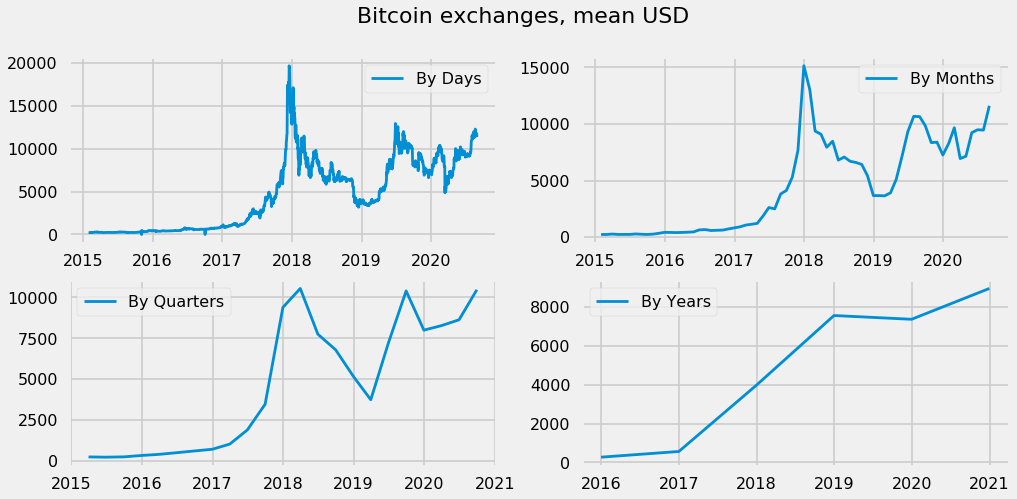

In [21]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.btc, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.btc, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.btc, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.btc, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()


Dickey–Fuller test: p=0.601320


<Figure size 1080x504 with 0 Axes>

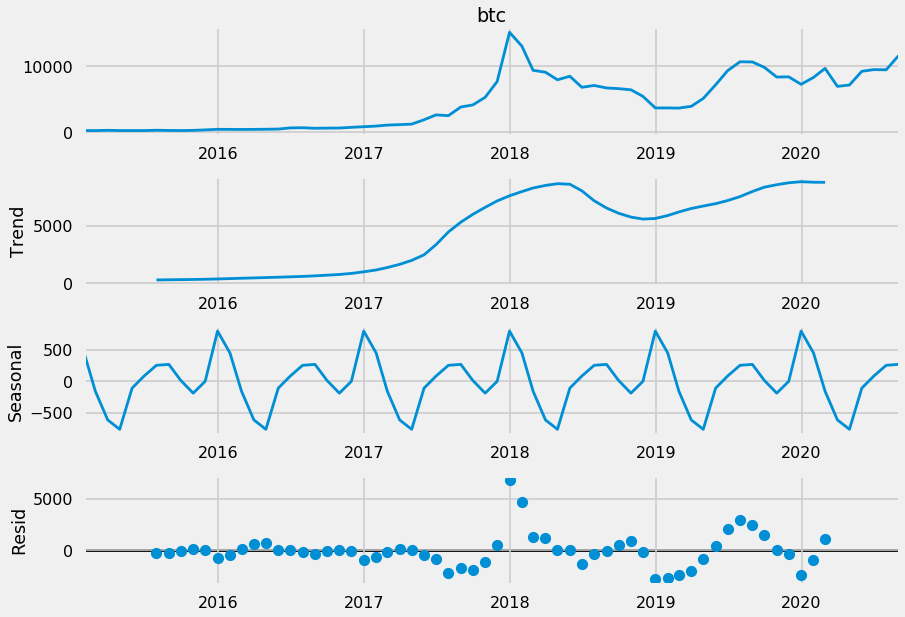

In [23]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.btc).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.btc)[1])
plt.show()

In [25]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.btc)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.btc)[1])

Dickey–Fuller test: p=0.601320


In [26]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.288516


Dickey–Fuller test: p=0.000020


<Figure size 1080x504 with 0 Axes>

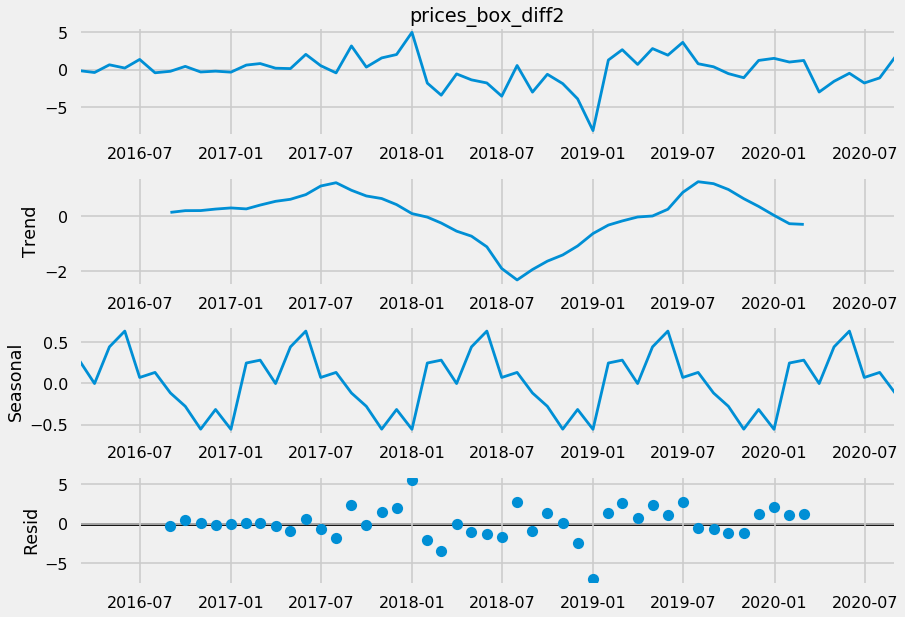

In [27]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

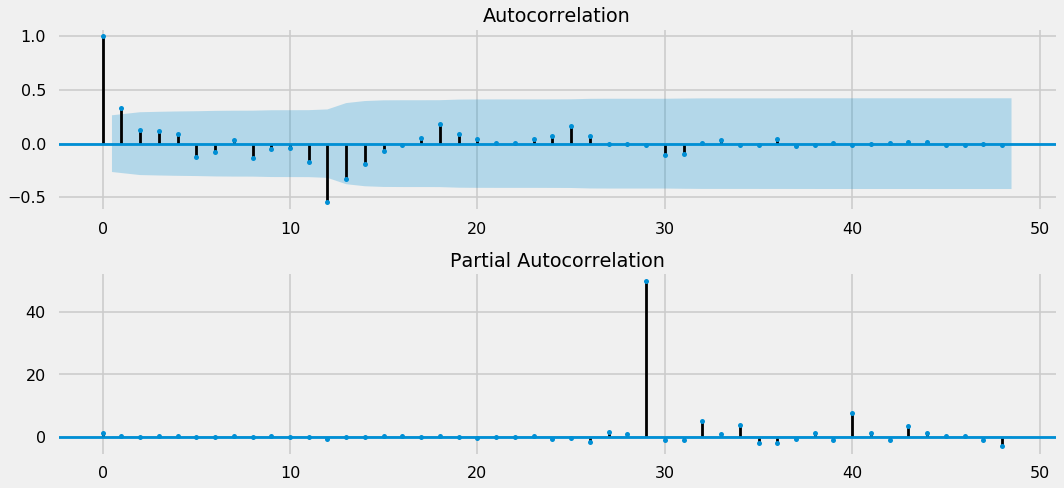

In [28]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [29]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [30]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
22  (1, 0, 2, 0)  204.869368
10  (0, 1, 2, 0)  205.011895
23  (1, 0, 2, 1)  205.698712
11  (0, 1, 2, 1)  206.428915
28  (1, 1, 2, 0)  206.846483
                                     SARIMAX Results                                      
Dep. Variable:                 Weighted_Price_box   No. Observations:                   68
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -98.435
Date:                            Wed, 26 Aug 2020   AIC                            204.869
Time:                                    11:29:35   BIC                            212.899
Sample:                                01-31-2015   HQIC                           207.974
                                     - 08-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


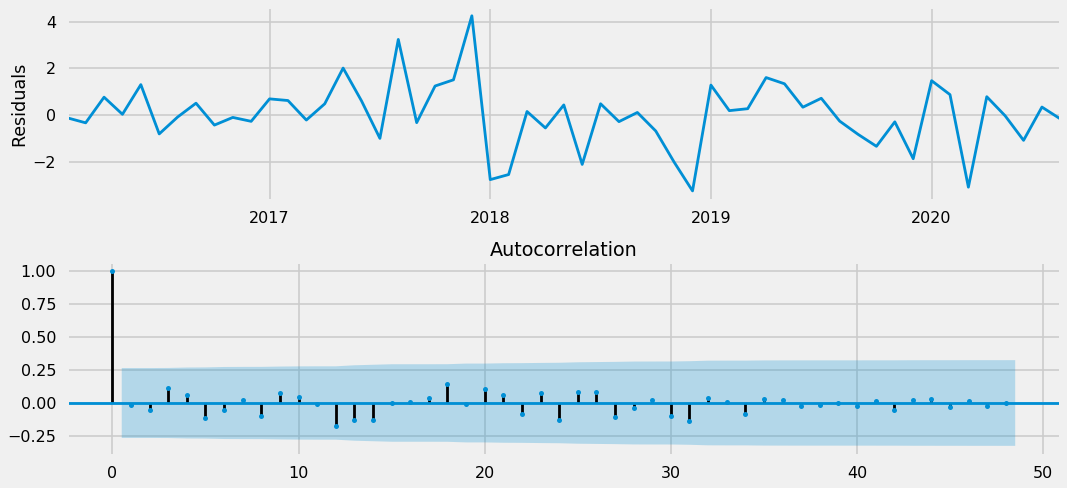

In [31]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [33]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

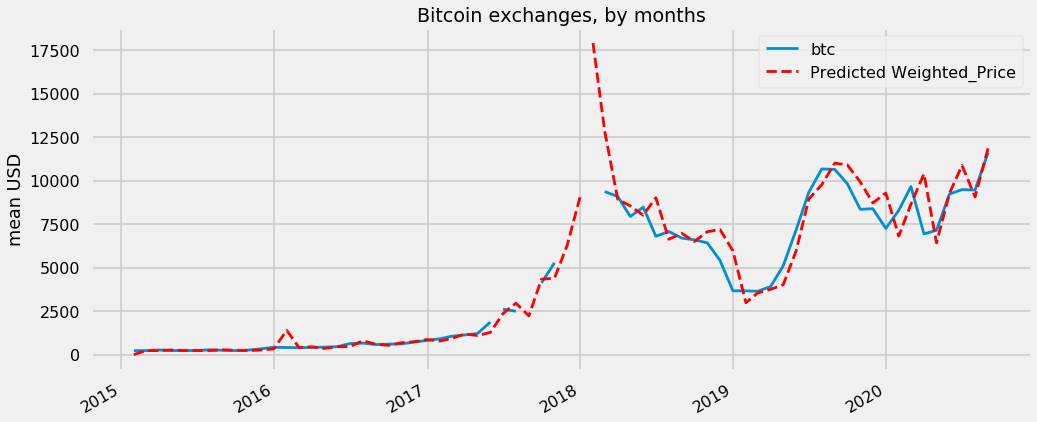

In [36]:
df_month2 = df_month[['btc']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.btc.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()